# Heuristic Approaches for TSP

In [1]:
# first we install the requirements
%pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


## Part 0: Generating and Visualizing a Random Instance

In order to run experiments, we need instances. 
For now, let us generate random instances by generating random coordinates in two dimensions.

In [2]:
import numpy as np

def random_tsp_instance(num_cities: int = 10, seed: int = 0) -> tuple:
    '''Create random TSP problem data'''

    # set of cities: 0..n-1
    CITIES = range(num_cities)  

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate random coordinates for cities
    X = 100 * np.random.rand(num_cities)
    Y = 100 * np.random.rand(num_cities)

    # Compute distance matrix
    dist = np.ceil(np.sqrt ((X.reshape(num_cities,1) - X.reshape(1,num_cities))**2 +
                            (Y.reshape(num_cities,1) - Y.reshape(1,num_cities))**2))
    
    return CITIES, X, Y, dist

CITIES, X, Y, dist = random_tsp_instance(10)


Let's check that our random instance looks interesting. 
Feel free to estimate the optimal tour by hand. 

We will directly add the option to pass the edges that will be the solution to the function. 
For now, we will only see the layout of the cities.

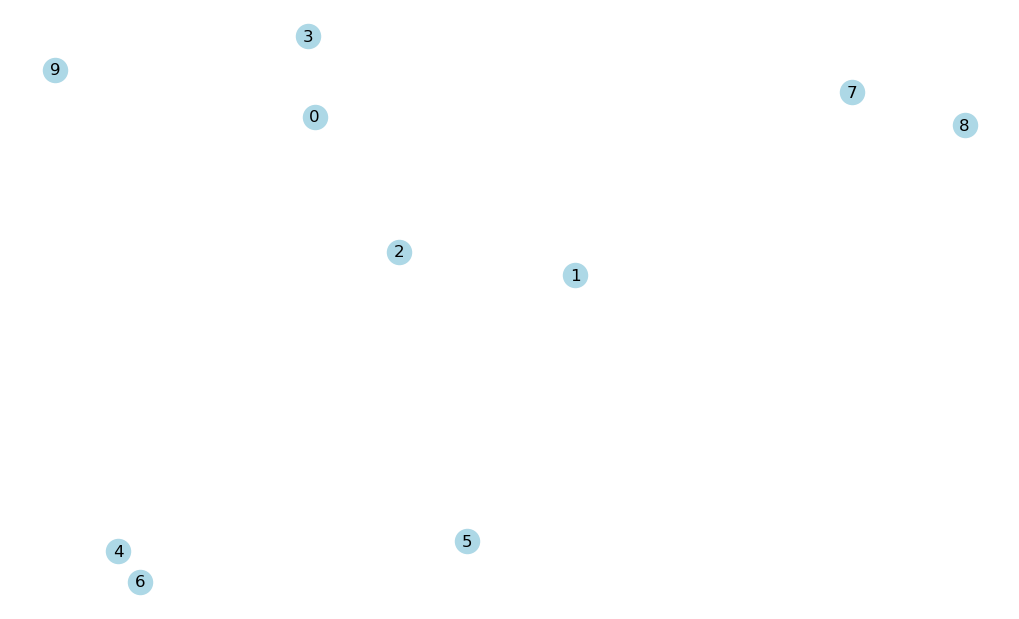

In [3]:
# Visualize solution using networkx and matplotlib
import networkx as nx 
import matplotlib.pyplot as plt

def plot_sol(CITIES, X, Y, edges: list = []) -> None:
    '''Plot the solution of the TSP problem'''

    # collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    # edges = []
    # for (i,j) in itertools.permutations(CITIES, 2):
    #     if model.getVal(x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
    #         edges.append( (i,j) )

    # create dictionary with coordinates for each node to plot the graph 
    xy = {}
    for i in CITIES:
        xy[i] = (X[i], Y[i])

    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = nx.Graph()

    # add edges
    optgraph.add_nodes_from(CITIES)  # add nodes
    optgraph.add_edges_from(edges)   # add edges

    # draw the nodes, with labels in the position xy (see when we read the instance)
    nx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

# Example usage of the plot_sol function
plot_sol(CITIES, X, Y) 

## Heuristic 1: Nearest Neighbor

The Nearest Neighbor heuristic is a simple and fast algorithm for solving the Traveling Salesman Problem (TSP). 
Starting from a chosen city, it repeatedly visits the nearest unvisited city until all cities are visited, then returns to the starting city. 
While it does not guarantee the optimal solution, it often produces a reasonable tour quickly and is useful for generating initial solutions or for small instances.

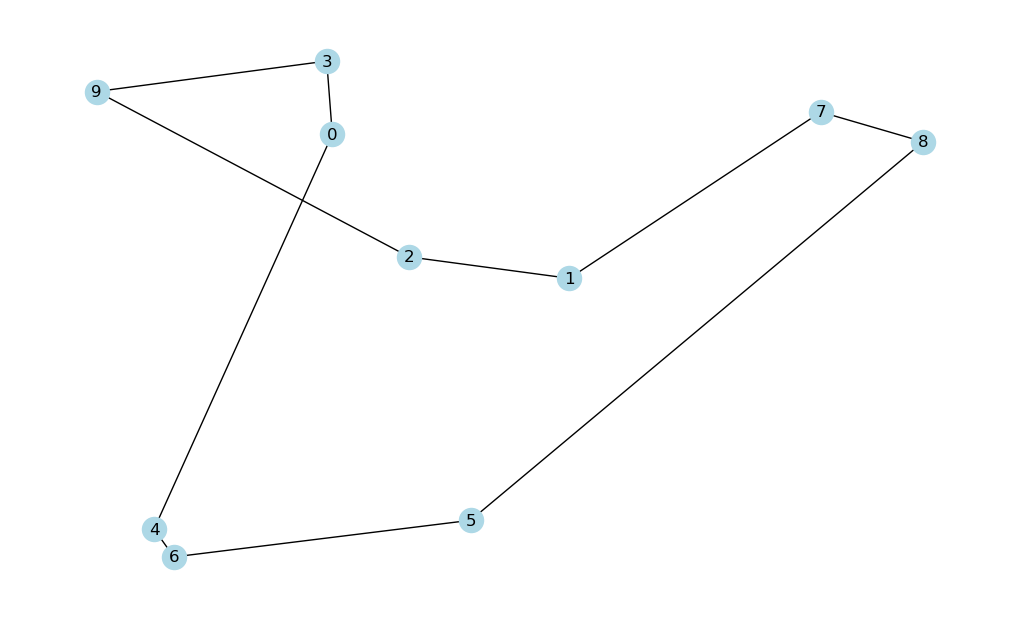

In [ ]:
def tsp_nearest_neighbor(CITIES, dist, start=0):
    '''Nearest Neighbor heuristic for TSP'''

    n = len(CITIES)
    unvisited = set(CITIES)
    tour = [start]
    unvisited.remove(start)
    current = start

    while unvisited:
        next_city = min(unvisited, key=lambda city: dist[current, city])
        tour.append(next_city)
        unvisited.remove(next_city)
        current = next_city

    # Return to start to complete the tour
    tour.append(start)
    return tour

# Run the heuristic
nn_tour = tsp_nearest_neighbor(CITIES, dist)

# Convert tour to edge list for plotting
nn_edges = [(nn_tour[i], nn_tour[i+1]) for i in range(len(nn_tour)-1)]

# Plot the solution
plot_sol(CITIES, X, Y, nn_edges)

## Heuristic 2: Furthest Insetion

The Furthest Insertion heuristic is a constructive algorithm for the Traveling Salesman Problem (TSP). 
It begins by identifying the two cities that are the furthest apart and initializes a subtour with these cities. 
At each step, the algorithm selects the unvisited city that is furthest from any city currently in the tour. 
This city is then inserted into the position in the tour that results in the smallest possible increase in the total tour length. 
The process repeats until all cities are included in the tour.
While not guaranteed to find the optimal solution, the Furthest Insertion heuristic often produces high-quality tours and is particularly effective for instances where cities are spread out.

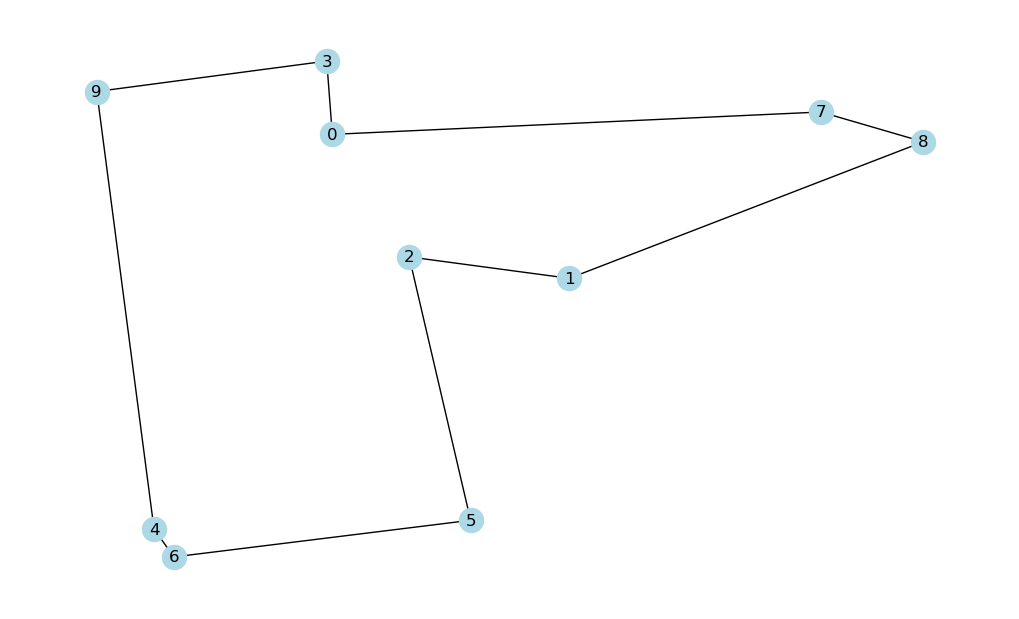

In [5]:
def tsp_furthest_insertion(CITIES, dist):
    '''Furthest Insertion heuristic for TSP'''

    n = len(CITIES)
    unvisited = set(CITIES)

    # Start with the two cities that are furthest apart
    max_dist = -1
    for i in CITIES:
        for j in CITIES:
            if i != j and dist[i, j] > max_dist:
                max_dist = dist[i, j]
                start, next_city = i, j

    tour = [start, next_city, start]
    unvisited.remove(start)
    unvisited.remove(next_city)

    while unvisited:
        # Find the unvisited city furthest from any city in the tour
        furthest_city = max(
            unvisited,
            key=lambda city: min(dist[city, t] for t in tour[:-1])
        )

        # Find the best place to insert the furthest city into the tour
        best_pos = None
        min_increase = float('inf')
        for i in range(len(tour) - 1):
            a, b = tour[i], tour[i + 1]
            increase = dist[a, furthest_city] + dist[furthest_city, b] - dist[a, b]
            if increase < min_increase:
                min_increase = increase
                best_pos = i + 1

        tour.insert(best_pos, furthest_city)
        unvisited.remove(furthest_city)

    return tour

# Run the heuristic
fi_tour = tsp_furthest_insertion(CITIES, dist)

# Convert tour to edge list for plotting
fi_edges = [(fi_tour[i], fi_tour[i+1]) for i in range(len(fi_tour)-1)]

# Plot the solution
plot_sol(CITIES, X, Y, fi_edges)

## Heuristic 3: 2-opt

The 2-opt heuristic is a popular local search algorithm for improving solutions to the Traveling Salesman Problem (TSP). 
Starting from an initial tour, the 2-opt method iteratively examines all possible pairs of edges and swaps them if the swap results in a shorter tour. 
This process continues until no further improvements can be made. 
While 2-opt does not guarantee an optimal solution, it is simple to implement and often produces significant improvements over greedy or constructive heuristics.

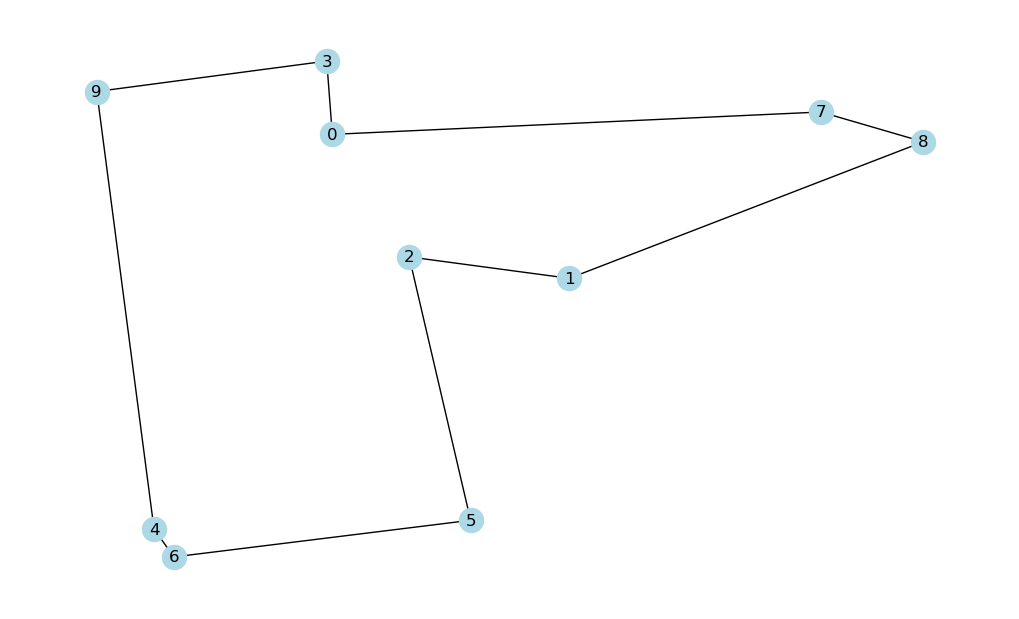

In [ ]:
def tsp_2opt(tour, dist):
    '''2-opt heuristic for TSP: improves a given tour by iteratively swapping edges'''

    best = tour[:]
    improved = True
    n = len(tour)
    
    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                # Calculate the cost difference if we swap edges (i-1,i) and (j,j+1)
                a, b = best[i - 1], best[i]
                c, d = best[j], best[j + 1]
                delta = (dist[a, c] + dist[b, d]) - (dist[a, b] + dist[c, d])
                if delta < 0:
                    # Perform the 2-opt swap
                    best[i:j + 1] = best[i:j + 1][::-1]
                    improved = True
        # Optionally, break early if no improvement
        if not improved:
            break
    return best

# Run 2-opt starting from the nearest neighbor tour
opt_tour = tsp_2opt(nn_tour, dist)

# Convert tour to edge list for plotting
opt_edges = [(opt_tour[i], opt_tour[i+1]) for i in range(len(opt_tour)-1)]

# Plot the improved tour
plot_sol(CITIES, X, Y, opt_edges)